In [2]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

from box_utils import prepare_boxes_plot, mul_intervals, pow_interval, neg_interval, subtr_intervals
from boxapprox import box_parallel, box_serial, approximate_boxes
# %matplotlib widget

Использование алгоритма для двузвенника

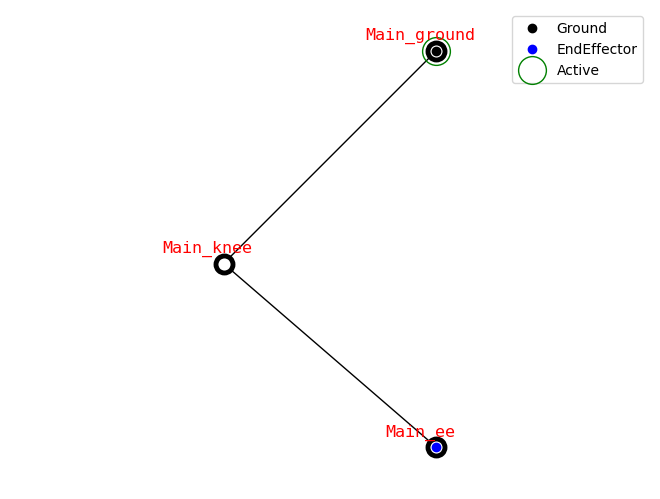

In [3]:
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator
from auto_robot_design.description.utils import draw_joint_point

gen = TwoLinkGenerator()
gen.build_standard_two_linker()
graph = gen.graph

draw_joint_point(graph)

In [4]:
from auto_robot_design.description.mechanism import JointPoint2KinematicGraph
from auto_robot_design.description.utils import draw_links

kinematic_graph = JointPoint2KinematicGraph(graph)
# draw_links(kinematic_graph, graph)
from auto_robot_design.description.utils import draw_kinematic_graph
# draw_kinematic_graph(kinematic_graph)
main_branch = kinematic_graph.define_main_branch()
# draw_kinematic_graph(main_branch)
kin_tree = kinematic_graph.define_span_tree()
# draw_kinematic_graph(kin_tree)

L3 (array([[-0.70710678, -0.        , -0.70710678],
       [ 0.        ,  1.        , -0.        ],
       [ 0.70710678,  0.        , -0.70710678]]), array([0., 0., 0.]))
G (array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), array([0., 0., 0.]))
L4 (array([[-0.65347871,  0.        ,  0.7569449 ],
       [ 0.        ,  1.        ,  0.        ],
       [-0.7569449 ,  0.        , -0.65347871]]), array([-0.148,  0.   , -0.148]))
EE (array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), array([ 0.     ,  0.     , -0.27577]))


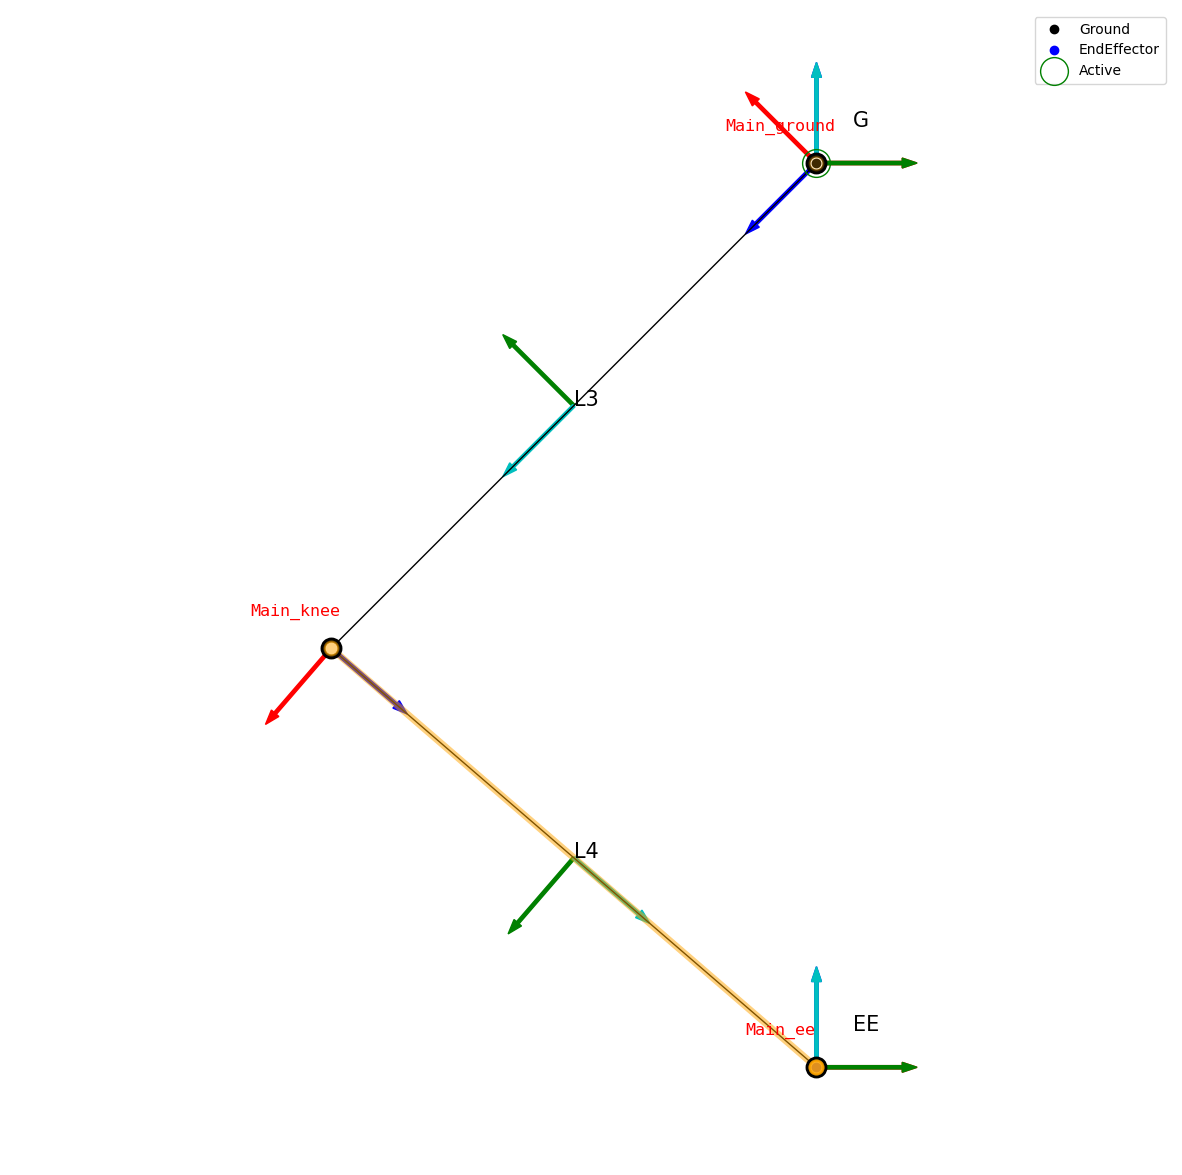

In [5]:
import modern_robotics as mr
from auto_robot_design.description.utils import draw_link_frames
from auto_robot_design.description.actuators import TMotor_AK80_9

thickness = 0.04
density = 2700 / 2.8

for n in kinematic_graph.nodes():
    n.thickness = thickness
    n.density = density

for j in kinematic_graph.joint_graph.nodes():
    j.pos_limits = (-np.pi, np.pi)
    if j.jp.active:
        j.actuator = TMotor_AK80_9()
    j.damphing_friction = (0.05, 0)
    
kinematic_graph.define_link_frames()
for l in kinematic_graph.nodes():
    print(l.name, mr.TransToRp(l.frame))
    # print(next(iter(l.joints)).jp.r)

draw_link_frames(kinematic_graph)
draw_links(kinematic_graph, graph)

In [9]:
# rxb = np.array([-1.5,1.5])
# ryb = np.array([-1.5,0.])

# rxb = np.array([-1.5,1.5])
# ryb = np.array([-1.5,0.])

rxb = np.array([-.45,.45])
ryb = np.array([-.5,0.])

un_b = np.array([-1., 1.])

# for each i joint
# rj+Rj pij = rk+Rk pik
#by components 
# rj1 + cj pi1j - sj pi2j = rk1 + ck pi1k - sk pi2k
# rj2 + sj pi1j + cj pi2j = rk2 + sk pi1k + ck pi2k

# for each link 
# R is valid so
# c2 + s2 = 1
# c2 = c**2
# s2 = s**2

# X: [rj1, rj2, cj, sj, cj2, sj2, ...]
#n_j=2 long equations 
#n_l=2 parameters count
# links_reduced = {kinematic_graph.nodes()} - {kinematic_graph.EE, kinematic_graph.G}
links = {n.name: n for n,d in kinematic_graph.nodes(data=True)}
js1 = list(links['L3'].joints)
js2 = list(links['L4'].joints)
rb_j = np.full((len(links)-1,2,2),None) #links-ee
#TODO add smart filling of rb_j
rb_j[0,0,:] = np.zeros(2)
rb_j[0,1,:] = np.zeros(2)
rb_j[1,0,:] = rxb
rb_j[1,1,:] = ryb
rb_j[2,0,:] = rxb
rb_j[2,1,:] = ryb

# print(js2)

#p1 expressed in 0 frame
p1x0, p1y0 = 0., 0.

p1x1, p1y1 = 0., 0. #TODO check if there are only 2
p2x1, p2y1 = 0., np.linalg.norm(js1[0].jp.r-js1[1].jp.r)

p2x2, p2y2 = 0., 0.

eex2, eey2 = 0., np.linalg.norm(js2[0].jp.r-js2[1].jp.r)

# p1x1, p1y1 = 0., 0.
# p2x1, p2y1 = 0., np.linalg.norm(js1[0].jp.r-js1[1].jp.r) #TODO check if there are only 2

# p2x2, p2y2 = 0., 0.

# eex2, eey2 = 0., np.linalg.norm(js2[0].jp.r-js2[1].jp.r)

p_i = np.full((len(links)-1,2+1,2),None) #links-ee, joints +ee, ncoords
# p_i[0,0,:] = [p1x0,p1y0]
p_i[1,0,:] = [p1x1,p1y1]
p_i[1,1,:] = [p2x1,p2y1]
p_i[2,1,:] = [p2x2,p2y2]
p_i[2,2,:] = [eex2,eey2]

B = np.asarray([rxb,ryb,un_b,un_b,pow_interval(un_b,2),pow_interval(un_b,2),
                rxb,ryb,un_b,un_b,pow_interval(un_b,2),pow_interval(un_b,2),
                rxb,ryb]) #ee coords

A_eq = np.array([[1,0,p1x1,-p1y1,0,0, #1 joint
                  0,0,0,0,0,0, 0,0],
                  [0,1,p1y1,p1x1,0,0,
                  0,0,0,0,0,0, 0,0],
                  [1,0,p2x1,-p2y1,0,0, #2 joint
                  -1,0,-p2x2,p2y2,0,0, 0,0],
                  [0,1,p2y1,p2x1,0,0,
                  0,-1,-p2y2,-p2x2,0,0, 0,0],
                  [0,0,0,0,1,1, #link 1 trig
                   0,0,0,0,0,0, 0,0], 
                   [0,0,0,0,0,0, #link 2 trig
                   0,0,0,0,1,1, 0,0],
                  [0,0,0,0,0,0, # ee
                   1,0,eex2,-eey2,0,0, -1,0],
                  [0,0,0,0,0,0,
                   0,1,eey2,eex2,0,0, 0,-1]])
b_eq = np.array([p1x0,p1y0,0,0,1,1, 
                 0,0]) # правые части равенств

# for every independent loop we equalize sum of twists before and after some link
# if loops have common links, we pick first link where they merge to 1 loop
# wj Sj + ... = wk Sk + ...
#sum of twists from ground to EE (T's components are first variables in m where L m=0)   
# T = wj Sj + ...  
# expanded 
# vx = wj sjx + ...
# vy = wj sjy + ...
# w = wj 1 + ...

# m: [vx,vy,w,wi...]
# ms: [vxs,vys,ws,wis...]
# Sj = [sjx,sjy,1] (so omit 1 from vars: [sjx,sjy])   sjx=Pjy sjy=-Pjx (global coords of j-th joint)
# fj = [fjx, fjy]   fjx = sjx wj, fjy = sjy wj

# new X: [m, ms, Sj..., fj,...]

# T path (joints): 1,2
#X: [vx,vy,w,w1,w2, 
#    vxs,vys,ws,w1s,w2s, 
#    s1x,s1y, s2x,s2y,
#    f1x,f1y, f2x,f2y]

# m: [vx,vy,w,wact,wpas...]
# mv: [wact...]
# my: [vx,vy,w,wpas...]

# mu: [vx,vy]  mb with w
# mz: [w,wact,wpas...]
nj = 2
n_mob = 2
n_loops = 0
shift = A_eq.shape[1]
q_act_inds = [0,1]  # in q
out_inds = [0,1]  # in T
mv_inds = [i+3 for i in q_act_inds]
mu_inds = out_inds

inds_2remove = mu_inds.copy() #TODO input here, and set flag
n_eps = 3+nj - len(inds_2remove)
inds_2remove.extend([i+3+nj for i in mu_inds])
# rhs = np.zeros(3+3*n_loops)
rhs = np.zeros(3) #TODO make smart

add_vars = 0
B2 = np.zeros((2*n_eps+4*nj+ add_vars,2))

#TODO try updating bounds with pow and mul during computation
# (shift+(3-len(out_inds))+ i, shift+2*(n_eps)+ i*2, shift+2*(n_eps)+2*nj+ i*2) # sx triplet (w,sx,fx)
is_rem_out = True
if is_rem_out:
    for i in range(n_eps):
        B2[i,:] = un_b
        B2[i+n_eps,:] = pow_interval(un_b,2)
    for i in range(nj): #intervals for sx, sy and fx, fy
        for j in range(p_i.shape[0]):
            if p_i[j,i,0] is not None:
                # six = yi = rjy + cj piyj + sj pixj
                # six = -(s px + c py)
                B2[2*(n_eps)+ i*2,:] = rb_j[j,1,:] + un_b*p_i[j,i,1] + un_b*p_i[j,i,0]  
                print(i, j, 'sx sum', rb_j[j,1,:], un_b*p_i[j,i,1], un_b*p_i[j,i,0])
                # siy = -xi = -rjx - cj pixj + sj piyj
                # siy = c px - s py
                B2[2*(n_eps)+1+ i*2,:] = neg_interval(subtr_intervals((rb_j[j,0,:] + un_b*p_i[j,i,0]), un_b*p_i[j,i,1]))
                print('sy sum  -',rb_j[j,0,:],'+',un_b*p_i[j,i,0],'-',un_b*p_i[j,i,1])

                B2[2*(n_eps)+2*nj+ i*2,:] = mul_intervals(un_b, B2[2*(n_eps)+ i*2,:]) #interval w*sx
                B2[2*(n_eps)+2*nj+1+ i*2,:] = mul_intervals(un_b, B2[2*(n_eps)+1+ i*2,:]) #interval w*sy
                break

A_eqT = np.array([[1,0,0, 0,0, # vx =...
                   0,0,0, 0,0,
                   0,0,0,0,
                   -1,0,-1,0], #TODO MB we dont need '-' here and below
                  [0,1,0, 0,0, # vy =...
                   0,0,0, 0,0,
                   0,0,0,0,
                   0,-1,0,-1],
                  [0,0,1, -1,-1, # w =... 
                   0,0,0, 0,0,
                   0,0,0,0,
                   0,0,0,0]])
# A_eqTs = np.array([[-1,0,0, 0,0, # vxs =...
#                    0,0,0, 0,0,
#                    0,0,0,0,
#                    1,0,1,0, 0.,0, 0,-1], 
#                   [0,-1,0, 0,0, # vys =...
#                    0,0,0, 0,0,
#                    0,0,0,0,
#                    0,1,0,1, 0,0., 1,0], #sum of sy*w
#                   [0,0,-1, 1,1, # ws =... 
#                    0,0,0, 0,0,
#                    0,0,0,0,
#                    0,0,0,0, 0,0, 0,0]])
# A_eqTb = np.array([[-1,0,0, 0,0, # vxb = -reey*ws + vxs
#                    0,0,0, 0,0,
#                    0,0,0,0,
#                    0,0,0,0, 1,0, 0,-1], #last 4 are veesx (vxs),veesy (vys), reex*ws, reey*ws
#                   [0,-1,0, 0,0, # vyb = reex*ws + vys
#                    0,0,0, 0,0,
#                    0,0,0,0,
#                    0,0,0,0, 0,1, 1,0]])
# if we have w in mz, we need to multiply it with ree (12,13), 
# else it is zero(we can delete last 2 vars) and we just equal vxs and vys to 0
# cross_Tb = [(12,14+0,14+2*n_eps+4*nj+ 2),(13,14+0,14+2*n_eps+4*nj+ 3)]

Lz = A_eqT.copy()
# Lz = np.vstack((A_eqTs.copy(),A_eqTb.copy()))
# Lz = A_eqTs.copy()
Lz = np.delete(Lz,inds_2remove,1)
### Lz = np.delete(Lz,0,1)
# Lz = np.delete(Lz,2,0)
# if Lz.shape[1] != n_eps*2+4*nj: #or Lz.shape[0] != nj:
#     raise ValueError("height of L for non-redundant must be =nj")
#body twists
A_eqS = np.array([[0,0,-p2y1,-p2x1,0,0, # s1x
                    0,0,0,0,0,0, 0,0,
                    0,0,0, 0,0,
                    0,0,0, 0,0,
                    -1,0,0,0,
                    0,0,0,0],
                    [0,0,p2x1,-p2y1,0,0, # s1y
                    0,0,0,0,0,0, 0,0,
                    0,0,0, 0,0,
                    0,0,0, 0,0,
                    0,-1,0,0,
                    0,0,0,0],
                  [0,0,0,0,0,0, # s2x
                  0,0,-eey2,-eex2,0,0, 0,0,
                  0,0,0, 0,0,
                  0,0,0, 0,0,
                  0,0,-1,0,
                  0,0,0,0],
                  [0,0,0,0,0,0, # s2y
                  0,0,eex2,-eey2,0,0, 0,0,
                  0,0,0, 0,0,
                  0,0,0, 0,0,
                  0,0,0,-1,
                  0,0,0,0]])

#spatial twists
# six = yi = rjy + cj piyj + sj pixj
# siy = -xi = -rjx - cj pixj + sj piyj
# A_eqS = np.array([[0,1,p1y1,p1x1,0,0, # s1x
#                     0,0,0,0,0,0, 0,0,
#                     0,0,0, 0,0,
#                     0,0,0, 0,0,
#                     -1,0,0,0,
#                     0,0,0,0],
#                     [-1,0,-p1x1,p1y1,0,0, # s1y
#                     0,0,0,0,0,0, 0,0,
#                     0,0,0, 0,0,
#                     0,0,0, 0,0,
#                     0,-1,0,0,
#                     0,0,0,0],
#                   [0,0,0,0,0,0, # s2x
#                   0,1,p2y2,p2x2,0,0, 0,0,
#                   0,0,0, 0,0,
#                   0,0,0, 0,0,
#                   0,0,-1,0,
#                   0,0,0,0],
#                   [0,0,0,0,0,0, # s2y
#                   -1,0,-p2x2,p2y2,0,0, 0,0,
#                   0,0,0, 0,0,
#                   0,0,0, 0,0,
#                   0,0,0,-1,
#                   0,0,0,0]])
A_eqSz = A_eqS.copy()
A_eqSz = np.delete(A_eqSz,[i+shift for i in inds_2remove], 1)

b_eqT = np.zeros(Lz.shape[0])
# ([0-p1y0,0+p1x0, # zeros because r0 = [0,0] for any mechanism. 
# ,0,0])
b_eqS = np.array([0,0,
                  0,0])

eps_length = 1.
A_eq_eps = np.array([[0,0,0, 0,0, # vector m is not zero
                      1,1,1, 1,1,
                      0,0,0,0,
                      0,0,0,0]])
A_eq_epsz = A_eq_eps.copy()
A_eq_epsz = np.delete(A_eq_epsz,inds_2remove,1)

b_eq_eps = np.array([eps_length])

# m_length_lb = 0.01
# A_ub_m = np.array([[0,0,0, 0,0, # vector m is not zero
#                    -1,-1,-1, -1,-1,
#                    0,0,0,0,
#                    0,0,0,0]])
# b_ub_m = np.array([-m_length_lb])


# [0,0,0,0,0,0, # s1x simpler because in 0 frame
# 0,0,0,0,0,0, 0,0,
# 0,0,0, 0,0,
# 0,0,0, 0,0,
# -1,0,0,0,
# 0,0,0,0],
# [0,0,0,0,0,0, # s1y simpler because in 0 frame
# 0,0,0,0,0,0, 0,0,
# 0,0,0, 0,0,
# 0,0,0, 0,0,
# 0,-1,0,0,
# 0,0,0,0],

sqr_pairs_0 = [(2,4), (3,5), #link1
             (8,10), (9,11), #link2
            #  (shift+0,shift+5),(shift+1,shift+6),(shift+2,shift+7),(shift+3,shift+8),(shift+4,shift+9) # 3+nj for full L
             ]
sqr_pairs = sqr_pairs_0.copy()
for i in range(n_eps):
    sqr_pairs.append((shift+i, shift+n_eps+i))

# indexes for hyperbolic terms
#wi = shift + 3 + j_ind                  (starting from 0) #works for full L and m #TODO fix for deleting wis
#six = shift + 2*(3+nj) + j_ind*nj
#siy = shift + 2*(3+nj) + j_ind*nj + 1
#fix = shift + 2*(3+nj) + 2*nj + j_ind*nj
#fiy = shift + 2*(3+nj) + 2*nj + j_ind*nj + 1

cross_triplets = []
# cross_triplets = [(shift+3+ 0, shift+2*(3+nj)+ 0*nj, shift+2*(3+nj)+2*nj+ 0*nj), #j1   w sx
#                   (shift+3+ 0, shift+2*(3+nj)+1+ 0*nj, shift+2*(3+nj)+2*nj+1+ 0*nj), # w sy
#                   (shift+3+ 1, shift+2*(3+nj)+ 1*nj, shift+2*(3+nj)+2*nj+ 1*nj), #j2   w sx
#                   (shift+3+ 1, shift+2*(3+nj)+1+ 1*nj, shift+2*(3+nj)+2*nj+1+ 1*nj), # w sy
#                   ]
if is_rem_out:
    for i in range(nj):
        cross_triplets.append((shift+ i, shift+2*(n_eps)+ i*2, shift+2*(n_eps)+2*nj+ i*2))
        cross_triplets.append((shift+ i, shift+2*(n_eps)+1+ i*2, shift+2*(n_eps)+2*nj+1+ i*2))
    # cross_triplets.extend(cross_Tb)
# print(A_eq)

for i in range(2*n_eps,B2.shape[0]-add_vars):
    B2[i,:] = np.array([-1.5,1.5])
if add_vars > 0:
    for i in range(B2.shape[0] - add_vars,B2.shape[0]-2):
        B2[i,:] = np.array([0.,0.])
    for i in range(B2.shape[0] - add_vars+2,B2.shape[0]):
        B2[i,:] = np.array([-10.,10.])

B_merg = np.vstack((B,B2))
A_eq_merg = np.vstack((np.hstack((A_eq, np.zeros((A_eq.shape[0],Lz.shape[1])))),
                       np.hstack((np.zeros((Lz.shape[0],shift)),Lz)),
                       np.hstack((A_eqSz,np.zeros((A_eqSz.shape[0],add_vars)))),
                       np.hstack((np.zeros((A_eq_epsz.shape[0],shift)),A_eq_epsz,np.zeros((A_eq_epsz.shape[0],add_vars))))
                       ))
# print(Lz)
# print(A_eq_epsz)
# print(cross_triplets)
# print(sqr_pairs)
# print(A_eq_epsz)
b_eq_merg = np.concatenate((b_eq,b_eqT,b_eqS,b_eq_eps))

# print(B2)
print(Lz)

0 1 sx sum [-0.5 0.0] [-0.  0.] [-0.  0.]
sy sum  - [-0.45 0.45] + [-0.  0.] - [-0.  0.]
1 1 sx sum [-0.5 0.0] [-0.20930361  0.20930361] [-0.  0.]
sy sum  - [-0.45 0.45] + [-0.  0.] - [-0.20930361  0.20930361]
[[ 0  0  0  0  0  0  0  0  0  0 -1  0 -1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 -1  0 -1]
 [ 1 -1 -1  0  0  0  0  0  0  0  0  0  0  0]]


In [10]:
threshold_s_0 = [0.2, 0.2, 2, 2, 2, 2,
               0.2, 0.2, 2, 2, 2, 2,
               0.2, 0.2]
# threshold_s = [0.2, 0.2, 2, 2, 2, 2,
#                0.2, 0.2, 2, 2, 2, 2,
#                0.1, 0.1,
#                1,1,
#                1,1,
#                4,4,4,4,
#                4,4,4,4]
# threshold_s = B_merg[:,1]-B_merg[:,0]
# threshold_s[(12,13),] /= 8
threshold_s = {12: 0.9/8, 13: 0.5/8}
# threshold_s = 0.5/8
# threshold_s = [0.5]

# sols = box_parallel([B], A_eq, b_eq, sqr_pairs_0, threshold_s=threshold_s_0)
# sols = box_serial([B_merg], A_eq_merg, b_eq_merg, sqr_pairs, cross_triplets, threshold_s)
sols = box_parallel([B_merg], A_eq_merg, b_eq_merg, sqr_pairs, cross_triplets, threshold_s)
# sols = approximate_boxes(B_merg, A_eq_merg, b_eq_merg, sqr_pairs, cross_triplets, threshold_s)

# for s in sols:
#     print(s)
# print(len(sols))

Starting box approximation on 11 processes.
-------------------
unexplored: 1
unexplored: 2
unexplored: 4
unexplored: 8
unexplored: 16
unexplored: 32
unexplored: 64
unexplored: 128
unexplored: 256
unexplored: 512
unexplored: 1024


KeyboardInterrupt: 

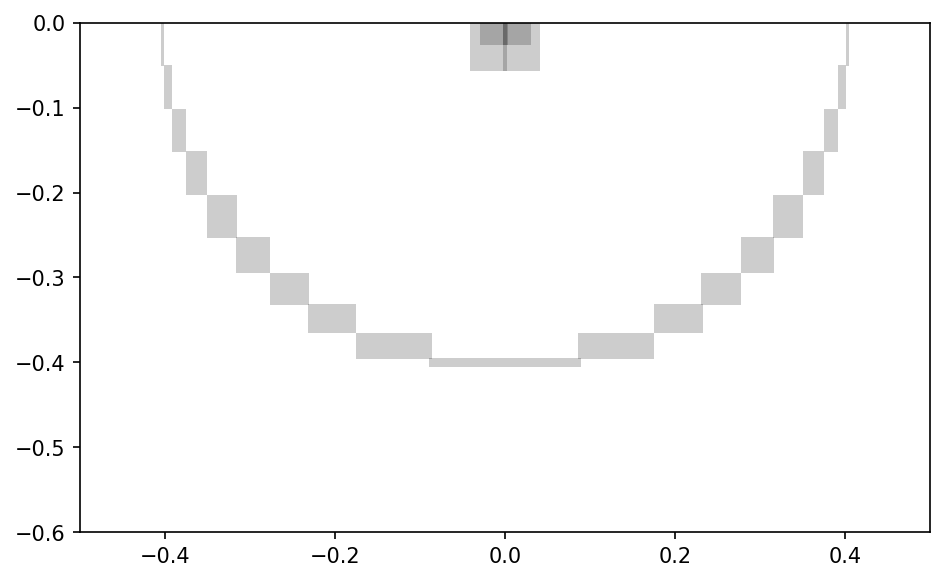

In [8]:
xl = np.array([-.5,.5])
yl = np.array([-.6,0.])

fig = plt.figure(dpi=150)
ax = plt.gca()

#TODO ПОМНИМ ЧТО БЫВАЕТ НАХОДИТ РЕШЕНИЯ В КОРОБКЕ С некоторыми НУЛЕВЫМИ СТОРОНАМИ
x_ind = 12
y_ind = 13

for b in sols[::]:
    # print(b)
    xlb, xub = b[x_ind,0], b[x_ind,1]
    ylb, yub = b[y_ind,0], b[y_ind,1]
    ax.add_patch(Rectangle((xlb,ylb),xub-xlb,yub-ylb,linewidth=1/2,edgecolor=None,facecolor='k',alpha=.1))

plt.xlim(xl)
plt.ylim(yl)

ax.set_aspect(1)
plt.tight_layout()

plt.show()

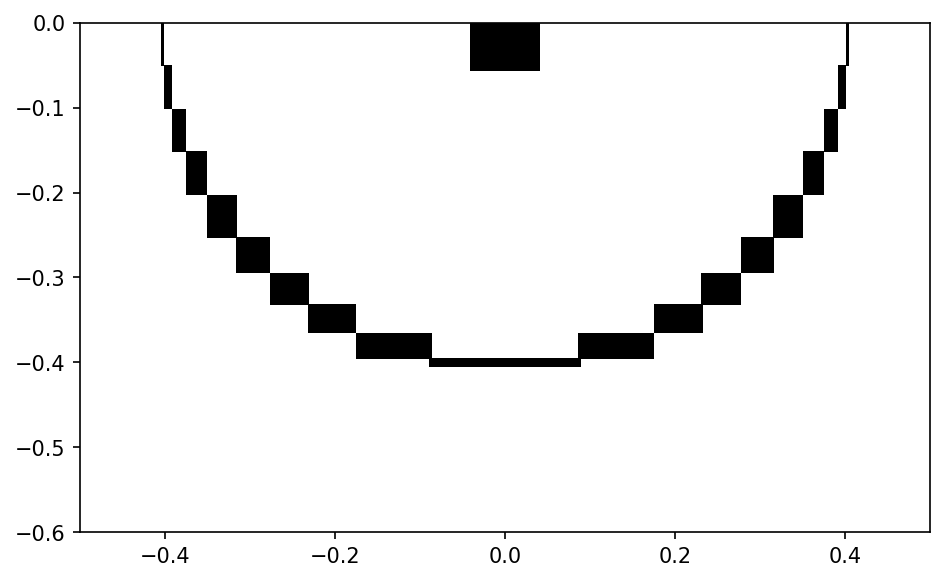

In [27]:
xl = np.array([-.5,.5])
yl = np.array([-.6,0.])

fig = plt.figure(dpi=150)
ax = plt.gca()

x_ind = 12
y_ind = 13

for b in sols[::]:
    # print(b)
    xlb, xub = b[x_ind,0], b[x_ind,1]
    ylb, yub = b[y_ind,0], b[y_ind,1]
    ax.add_patch(Rectangle((xlb,ylb),xub-xlb,yub-ylb,linewidth=1/2,edgecolor=None,facecolor='k',alpha=1))

plt.xlim(xl)
plt.ylim(yl)

ax.set_aspect(1)
plt.tight_layout()

plt.show()